In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm

## Utils

In [2]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df[col]=[cleanhtml(text) for text in df[col]]
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'

## Read and clean posts data

In [3]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)
posts_df.head()

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,NaN,0,NaN,5,0,1,8,<machine-learning>,How can I do simple machine learning without h...,412
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,NaN,97,NaN,36,0,1,4,<education><open-source>,What open-source books (or other materials) pr...,363
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,NaN,0,NaN,51,5,2,5,NaN,NaN,0
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,NaN,0,NaN,22,7,2,12,NaN,NaN,0
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,NaN,322,NaN,66,0,1,19,<data-mining><definitions>,Is Data Science the Same as Data Mining?,999


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [4]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8884
Answer             7323
Accepted answer    3006
Name: post_label, dtype: int64

## Read and clean comments data
*Not sure if we need the comments. Read this data anyway

In [5]:
tree = ET.parse('data/Comments.xml')
root = tree.getroot()
comments_df=pd.DataFrame([x.attrib for x in root.getchildren()])
comments_df.columns

int_columns = ['Id','PostId','Score','UserId']
datetime_columns = ['CreationDate']
text_columns = ['Text']

comments_df = clean_dataframe(comments_df,int_columns,datetime_columns,text_columns)

In [8]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

## Questions score distribution

In [12]:
questions_scores = posts_df[posts_df["post_label"]=="Question"]["Score"]

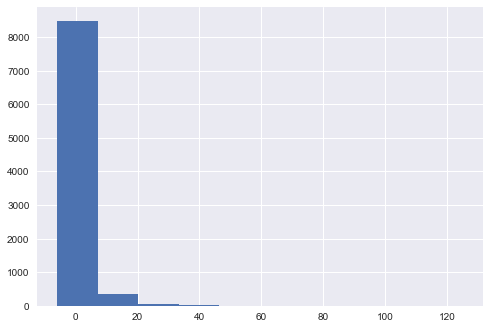

In [13]:
show_distribution(questions_scores)

In [18]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [19]:
low_ranked_question_threshold = 0.0
low_ranked_question_threshold

0.0

## Answers score distribution

In [20]:
answers_scores = posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"]

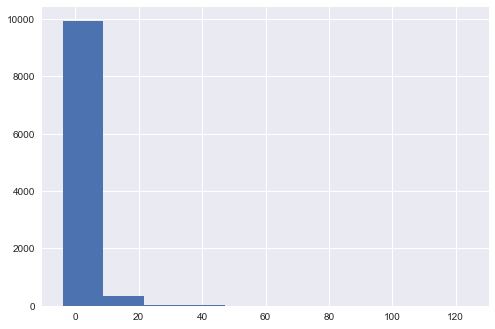

In [23]:
show_distribution(answers_scores)

In [24]:
high_ranked_answers_threshold = np.percentile(questions_scores, 90)
high_ranked_answers_threshold

5.0

In [26]:
low_ranked_answers_threshold = 0.0
low_ranked_answers_threshold

0.0

## Label the posts rank

In [27]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [29]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11510
Low        5435
High       2268
Name: post_rank, dtype: int64